In [1]:
# Εγκατάσταση των βιβλιοθηκών numpy (για αριθμητικούς υπολογισμούς), pandas (για επεξεργασία δεδομένων),
# matplotlib και seaborn (για οπτικοποίηση δεδομένων), scikit-learn (για machine learning) και torch (για deep learning)
# Οι βιβλιοθήκες είναι ήδη εγκατεστημένες στο περιβάλλον και δεν χρειάζεται να τις ξαναεγκαταστήσουμε.
# Αν κάποιος τρέξει το notebook σε νέο περιβάλλον, θα χρειαστεί να εκτελέσει την εξής εντολή για να εγκαταστήσει τις βιβλιοθήκες:
# !pip install numpy pandas matplotlib seaborn scikit-learn torch

In [106]:
# Εισαγωγή των απαραίτητων βιβλιοθηκών

import torch # για deep learning
import numpy as np # για αριθμητικούς υπολογισμούς
import torch.nn as nn # για νευρωνικά δίκτυα
import torch.optim as optim # για βελτιστοποίηση
from torch.utils.data import DataLoader, TensorDataset # για διαχείριση δεδομένων
import matplotlib.pyplot as plt # για οπτικοποίηση δεδομένων
import seaborn as sns # για οπτικοποίηση δεδομένων
import random
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score  # για αξιολόγηση μοντέλου
from sklearn.preprocessing import label_binarize # για μετατροπή ετικετών σε δυαδική μορφή
from sklearn.preprocessing import LabelEncoder # για μετατροπή ετικετών σε αριθμητικές τιμές
from sklearn.model_selection import KFold # για διαχωρισμό δεδομένων σε εκπαίδευση και δοκιμή



In [107]:
# Ορισμός του seed για αναπαραγωγιμότητα
seed = 42
random.seed(seed)  # Για τη βιβλιοθήκη random
np.random.seed(seed)  # Για τη βιβλιοθήκη NumPy

# Για PyTorch, αν το χρησιμοποιείς:
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Σε πολλαπλές GPU αν υπάρχουν

# Ρυθμίσεις για αναπαραγωγιμότητα με GPU
torch.backends.cudnn.deterministic = True  # Αναγκάζει ντετερμινιστικές πράξεις
torch.backends.cudnn.benchmark = False  # Απενεργοποιεί το benchmarking για τα βελτιστοποιημένα μεγέθη μπλοκ

# Ελέγχουμε εάν το seed έχει ρυθμιστεί σωστά
print(f"Random seed set to {seed}")

Random seed set to 42


In [108]:
# Ελέγχουμε αν υπάρχει GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Χρησιμοποιούμε τη συσκευή: {device}")

Χρησιμοποιούμε τη συσκευή: cuda


In [109]:
# Φορτώνουμε τα δεδομένα από το αρχείο που αποθηκεύσαμε

data = np.load('train_test_images_normalized_images.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
class_names = data['class_names']  # Φόρτωση των ονομάτων των κατηγοριών

# Εκτύπωση των σχημάτων και των ονομάτων των κατηγοριών
print(f"Φορτώθηκε το Σχήμα Συνόλου Εκπαίδευσης: {X_train.shape}, ετικέτες: {y_train.shape}")
print(f"Φορτώθηκε το Σχήμα Συνόλου Δοκιμής: {X_test.shape}, ετικέτες: {y_test.shape}")
print(f"Ονόματα Κατηγοριών: {class_names}")

Φορτώθηκε το Σχήμα Συνόλου Εκπαίδευσης: (2800, 4096), ετικέτες: (2800,)
Φορτώθηκε το Σχήμα Συνόλου Δοκιμής: (1200, 4096), ετικέτες: (1200,)
Ονόματα Κατηγοριών: ['BreastMRI' 'ChestCT' 'CXR' 'Hand']


In [110]:
# Μετατροπή των ετικετών σε κατηγορίες 
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Μετατροπή των δεδομένων σε PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

print(f"Τα δεδομένα είναι έτοιμα και μετατράπηκαν σε Tensors με σχήμα:")
print(f"X_train: {X_train_tensor.shape}, X_test: {X_test_tensor.shape}")
print(f"y_train: {y_train_tensor.shape}, y_test: {y_test_tensor.shape}")

Τα δεδομένα είναι έτοιμα και μετατράπηκαν σε Tensors με σχήμα:
X_train: torch.Size([2800, 4096]), X_test: torch.Size([1200, 4096])
y_train: torch.Size([2800]), y_test: torch.Size([1200])


Επιλέξαμε η αρχιτεκτονική του baseline μοντέλου να είναι σχετικά απλή με δύο κρυφά επίπεδα (512, 256) και χωρίς Batch Normalization, καθώς πιστεύουμε πως η συγκεκριμένη δομή είναι αρκετά αποδοτική για αρχικό πείραμα. Χρησιμοποιούμε ReLU ως συνάρτηση ενεργοποίησης για καλύτερη απόδοση και dropout 0.5 για να αποτρέψουμε το overfitting. Ο στόχος ήταν να διατηρηθεί η απλότητα και να εξετάσουμε τις βασικές παραμέτρους χωρίς περιττή πολυπλοκότητα. 

In [111]:
# Δημιουργία του MLP για το baseline μοντέλο
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.0, use_batchnorm=False):
        super(MLP, self).__init__()
        self.use_batchnorm = use_batchnorm
        self.layers = nn.ModuleList()  # Αρχικοποιούμε τη λίστα των layers
        in_size = input_size
        
        # Δημιουργία των κρυφών επιπέδων
        for hidden_size in hidden_sizes:
            self.layers.append(nn.Linear(in_size, hidden_size))  # Linear Layer
            if self.use_batchnorm: 
                self.layers.append(nn.BatchNorm1d(hidden_size))  # Batch Normalization 
            self.layers.append(nn.ReLU())  # Συναρτήσεις ενεργοποίησης ReLU
            self.layers.append(nn.Dropout(dropout_rate))  # Dropout για κανονικοποίηση
            in_size = hidden_size  # Ορίζουμε το in_size για το επόμενο επίπεδο

        # Εξοδος
        self.output = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        # Προώθηση μέσω των layers
        for layer in self.layers:
            x = layer(x)
        
        # Προώθηση μέσω του τελευταίου επιπέδου (output layer)
        x = self.output(x)
        
        return x

# Ορισμός υπερπαραμέτρων για το baseline
input_size = X_train_tensor.shape[1]  # 4096
output_size = len(np.unique(y_train))  # Ο αριθμός των κατηγοριών

# Παράμετροι για το baseline (απλές τιμές για πειραματισμό)
hidden_sizes = [512, 256]  # 2 κρυφά επίπεδα
dropout_rate = 0.5  # Dropout rate
use_batchnorm = False  # Χωρίς Batch Normalization
learning_rate = 0.001  # Learning rate
num_epochs = 20  # Αριθμός εποχών



Epoch 1/20 - Train Loss: 1.4144 - Train Accuracy: 24.18%
Epoch 2/20 - Train Loss: 0.4829 - Train Accuracy: 83.75%
Epoch 3/20 - Train Loss: 0.3812 - Train Accuracy: 86.82%
Epoch 4/20 - Train Loss: 0.1541 - Train Accuracy: 96.82%
Epoch 5/20 - Train Loss: 0.1417 - Train Accuracy: 95.96%
Epoch 6/20 - Train Loss: 0.1387 - Train Accuracy: 96.18%
Epoch 7/20 - Train Loss: 0.1235 - Train Accuracy: 97.04%
Epoch 8/20 - Train Loss: 0.0951 - Train Accuracy: 98.00%
Epoch 9/20 - Train Loss: 0.0854 - Train Accuracy: 98.32%
Epoch 10/20 - Train Loss: 0.0683 - Train Accuracy: 98.57%
Epoch 11/20 - Train Loss: 0.0502 - Train Accuracy: 99.00%
Epoch 12/20 - Train Loss: 0.0459 - Train Accuracy: 98.86%
Epoch 13/20 - Train Loss: 0.0443 - Train Accuracy: 99.04%
Epoch 14/20 - Train Loss: 0.0397 - Train Accuracy: 99.07%
Epoch 15/20 - Train Loss: 0.0526 - Train Accuracy: 98.75%
Epoch 16/20 - Train Loss: 0.0556 - Train Accuracy: 98.75%
Epoch 17/20 - Train Loss: 0.0409 - Train Accuracy: 99.07%
Epoch 18/20 - Train Los

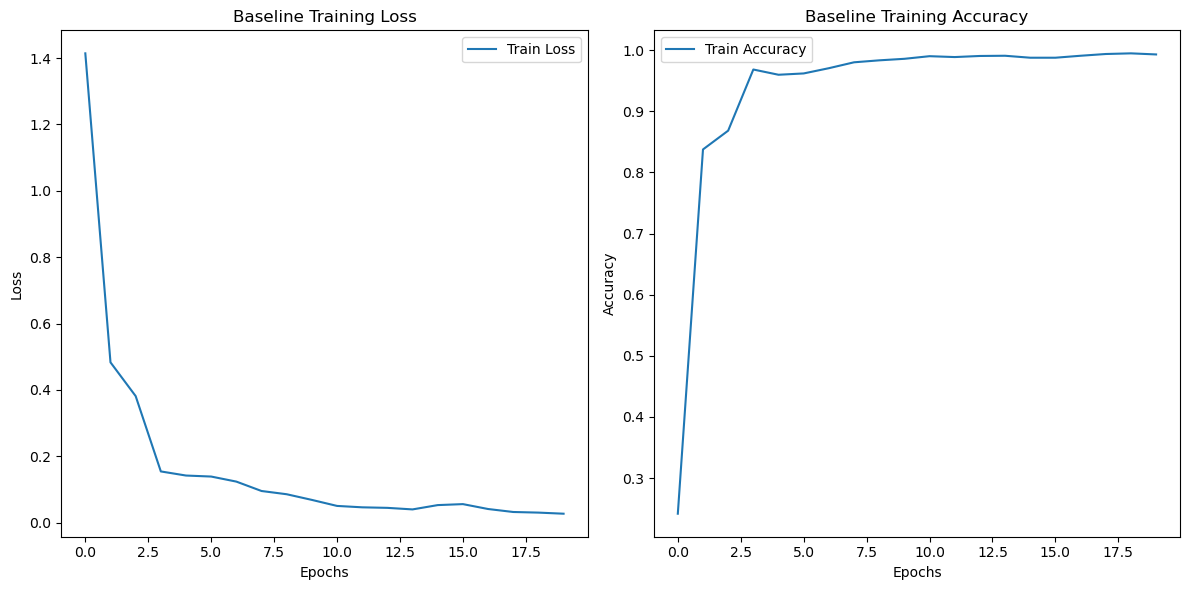

In [112]:
# Δημιουργία του Baseline Μοντέλου
baseline_model = MLP(input_size, hidden_sizes, output_size, dropout_rate, use_batchnorm).to(device)

# Ορισμός του Loss Function και του Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=learning_rate)

# Λίστες για την αποθήκευση της εκπαίδευσης
train_losses, train_accuracies = [], []

# Εκπαίδευση του μοντέλου για το baseline
for epoch in range(num_epochs):
    baseline_model.train()
    optimizer.zero_grad()
    
    # Forward pass για το train set
    outputs_train = baseline_model(X_train_tensor)
    loss_train = criterion(outputs_train, y_train_tensor)
    
    # Backward pass και βελτιστοποίηση
    loss_train.backward()
    optimizer.step()

    # Αποθήκευση του loss και της ακρίβειας για το train set
    train_losses.append(loss_train.item())
    _, predicted_train = torch.max(outputs_train, 1)
    train_accuracy = accuracy_score(y_train_tensor.cpu(), predicted_train.cpu())
    train_accuracies.append(train_accuracy)

    # Εμφάνιση της κατάστασης της εκπαίδευσης σε κάθε epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {loss_train.item():.4f} - Train Accuracy: {train_accuracy * 100:.2f}%")

# Οπτικοποίηση των καμπυλών μάθησης για το baseline
plt.figure(figsize=(12, 6))

# Καμπύλη Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Baseline Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Καμπύλη Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.title('Baseline Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



Final Test Accuracy: 99.33%

Classification Report:
              precision    recall  f1-score   support

   BreastMRI       0.99      1.00      1.00       300
     ChestCT       0.99      0.99      0.99       300
         CXR       1.00      1.00      1.00       300
        Hand       1.00      0.98      0.99       300

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



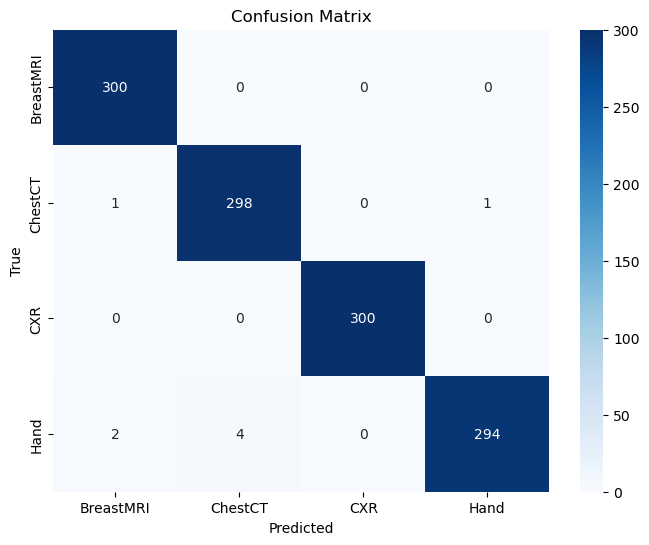

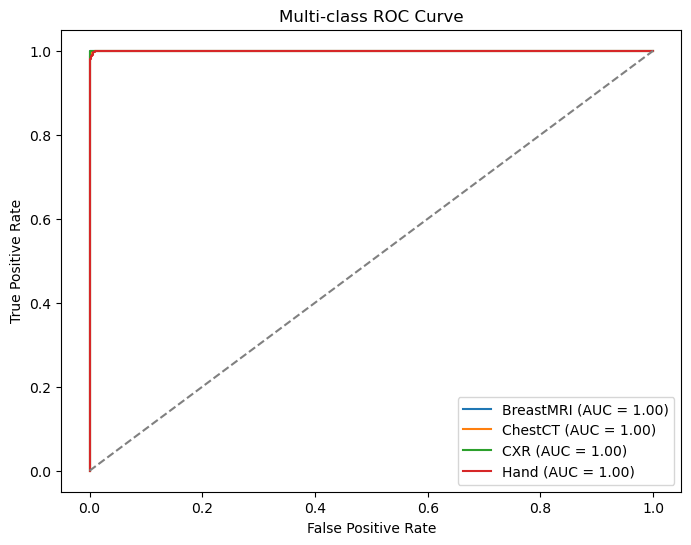

In [113]:
# Αξιολόγηση του μοντέλου στο test set μετά την ολοκλήρωση της εκπαίδευσης
baseline_model.eval()
with torch.no_grad():
    outputs_test = baseline_model(X_test_tensor)
    _, predicted_test = torch.max(outputs_test, 1)
    test_accuracy = accuracy_score(y_test_tensor.cpu(), predicted_test.cpu())
    print(f'\nFinal Test Accuracy: {test_accuracy * 100:.2f}%')

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test_tensor.cpu(), predicted_test.cpu(), target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test_tensor.cpu(), predicted_test.cpu())
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve - Multi-class ROC Curve
    y_test_bin = label_binarize(y_test_tensor.cpu(), classes=np.arange(len(class_names)))
    outputs_test_softmax = outputs_test.softmax(dim=1).cpu().numpy()  # Softmax για την εκτίμηση των πιθανοτήτων

    # Υπολογισμός του ROC Curve για κάθε κατηγορία
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], outputs_test_softmax[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plotting ROC Curve για κάθε κατηγορία
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

Επιπλέον πειραματισμοί

In [ ]:
# Υλοποίηση του MLP για πειραματισμό με διαφορετικές υπερπαραμέτρους
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.0, use_batchnorm=False, activation_fn=nn.ReLU):
        super(MLP, self).__init__()
        self.use_batchnorm = use_batchnorm
        self.layers = nn.ModuleList()  # Αρχικοποιούμε τη λίστα των layers
        in_size = input_size
        
        # Δημιουργία των κρυφών επιπέδων
        for hidden_size in hidden_sizes:
            self.layers.append(nn.Linear(in_size, hidden_size))  # Linear Layer
            if self.use_batchnorm: 
                self.layers.append(nn.BatchNorm1d(hidden_size))  # Batch Normalization (αν το ζητήσουμε)
            self.layers.append(activation_fn())  # Συναρτήσεις ενεργοποίησης (π.χ. ReLU, Sigmoid, Tanh)
            self.layers.append(nn.Dropout(dropout_rate))  # Dropout για κανονικοποίηση
            in_size = hidden_size  # Ορίζουμε το in_size για το επόμενο επίπεδο

        # Εξοδος
        self.output = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        # Προώθηση μέσω των layers
        for layer in self.layers:
            x = layer(x)
        
        # Προώθηση μέσω του τελευταίου επιπέδου (output layer)
        x = self.output(x)
        
        return x

# Ρυθμίσεις υπερπαραμέτρων για πειραματισμό
input_size = X_train_tensor.shape[1]  # 4096
hidden_sizes = [[512, 256], [512, 256, 128], [1024, 512]]  # Πειραματισμός με διαφορετικά μεγέθη
output_size = len(np.unique(y_train))  # Ο αριθμός των κατηγοριών
dropout_rates = [0.2, 0.5, 0.8]  # Πειραματισμός με διαφορετικούς ρυθμούς dropout
batchnorm_options = [True, False]  # Χρήση ή όχι Batch Normalization
activation_functions = [nn.ReLU, nn.Sigmoid, nn.Tanh]  # Πειραματισμός με διαφορετικές συναρτήσεις ενεργοποίησης
learning_rates = [0.001, 0.01, 0.0001]  # Πειραματισμός με διαφορετικούς ρυθμούς μάθησης

# Ορισμός του Loss Function
criterion = nn.CrossEntropyLoss()


Testing combination: hidden_size=[512, 256], dropout_rate=0.0, use_batchnorm=True, lr=0.001, num_epochs=10
Mean Validation Accuracy for this combination: 98.46%
Testing combination: hidden_size=[512, 256], dropout_rate=0.0, use_batchnorm=True, lr=0.001, num_epochs=20
Mean Validation Accuracy for this combination: 99.26%
Testing combination: hidden_size=[512, 256], dropout_rate=0.0, use_batchnorm=True, lr=0.01, num_epochs=10
Mean Validation Accuracy for this combination: 97.41%
Testing combination: hidden_size=[512, 256], dropout_rate=0.0, use_batchnorm=True, lr=0.01, num_epochs=20
Mean Validation Accuracy for this combination: 98.39%
Testing combination: hidden_size=[512, 256], dropout_rate=0.0, use_batchnorm=True, lr=0.1, num_epochs=10
Mean Validation Accuracy for this combination: 91.56%
Testing combination: hidden_size=[512, 256], dropout_rate=0.0, use_batchnorm=True, lr=0.1, num_epochs=20
Mean Validation Accuracy for this combination: 95.68%
Testing combination: hidden_size=[512, 2

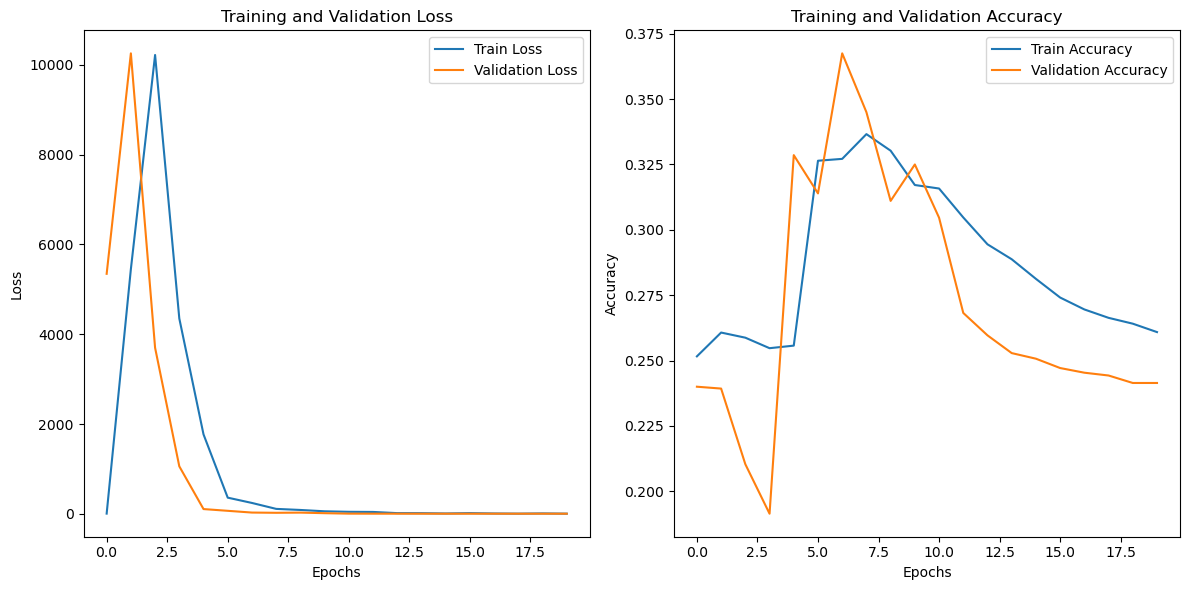

Best Params: {'hidden_sizes': [512, 256, 128], 'dropout_rate': 0.5, 'use_batchnorm': False, 'lr': 0.001, 'num_epochs': 20}
Best Cross-Validation Accuracy: 99.53%


In [116]:
# Συνάρτηση για την εκπαίδευση και αξιολόγηση του μοντέλου σε κάθε fold του Cross-Validation
def train_and_evaluate_cv(model, X_train_tensor, y_train_tensor, fold_train_idx, fold_val_idx, optimizer, criterion, num_epochs):
    # Χωρίζουμε τα δεδομένα σε train και validation για αυτό το fold
    X_train_fold, X_val_fold = X_train_tensor[fold_train_idx], X_train_tensor[fold_val_idx]
    y_train_fold, y_val_fold = y_train_tensor[fold_train_idx], y_train_tensor[fold_val_idx]
    
    # Αποθήκευση τιμών για την οπτικοποίηση
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Εκπαίδευση του μοντέλου
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass για το train set
        outputs_train = model(X_train_fold)
        loss_train = criterion(outputs_train, y_train_fold)
        
        # Backward pass και βελτιστοποίηση
        loss_train.backward()
        optimizer.step()

        # Αποθήκευση του loss και της ακρίβειας για το train set
        train_losses.append(loss_train.item())
        _, predicted_train = torch.max(outputs_train, 1)
        train_accuracy = accuracy_score(y_train_fold.cpu(), predicted_train.cpu())
        train_accuracies.append(train_accuracy)

        # Υπολογισμός του loss και της ακρίβειας για το validation set
        model.eval()
        with torch.no_grad():
            outputs_val = model(X_val_fold)
            loss_val = criterion(outputs_val, y_val_fold)
            val_losses.append(loss_val.item())
            _, predicted_val = torch.max(outputs_val, 1)
            val_accuracy = accuracy_score(y_val_fold.cpu(), predicted_val.cpu())
            val_accuracies.append(val_accuracy)

    # Επιστρέφουμε τις τιμές για οπτικοποίηση
    return train_losses, train_accuracies, val_losses, val_accuracies

# Ορισμός του Κριτηρίου
criterion = nn.CrossEntropyLoss()

# Δημιουργία του Cross-Validation αντικειμένου
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Χρησιμοποιούμε 5 folds

# Ορισμός υπερπαραμέτρων για το Grid Search
param_grid = {
    'hidden_sizes': [[512, 256], [1024, 512], [512, 256, 128]],
    'dropout_rate': [0.0, 0.25, 0.5],
    'use_batchnorm': [True, False],
    'lr': [0.001, 0.01, 0.1],
    'num_epochs': [10, 20]
}

# Cross-validation με Grid Search
best_accuracy = 0.0
best_params = None
cv_train_accuracies = []

# Εκτέλεση του Grid Search για κάθε συνδυασμό υπερπαραμέτρων
for hidden_size in param_grid['hidden_sizes']:
    for dropout_rate in param_grid['dropout_rate']:
        for use_batchnorm in param_grid['use_batchnorm']:
            for lr in param_grid['lr']:
                for num_epochs in param_grid['num_epochs']:
                    print(f"Testing combination: hidden_size={hidden_size}, dropout_rate={dropout_rate}, use_batchnorm={use_batchnorm}, lr={lr}, num_epochs={num_epochs}")
                    
                    # Αρχικοποιούμε το μοντέλο με τις τρέχουσες υπερπαράμετρους
                    model = MLP(input_size, hidden_size, output_size, dropout_rate, use_batchnorm).to(device)
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                    
                    # Κάνουμε Cross-Validation για αυτήν τη συνδυασμένη παραμετροποίηση
                    fold_train_losses, fold_train_accuracies, fold_val_losses, fold_val_accuracies = [], [], [], []
                    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_tensor)):
                        train_losses, train_accuracies, val_losses, val_accuracies = train_and_evaluate_cv(
                            model, X_train_tensor, y_train_tensor, train_idx, val_idx, optimizer, criterion, num_epochs)
                        
                        fold_train_losses.append(train_losses)
                        fold_train_accuracies.append(train_accuracies)
                        fold_val_losses.append(val_losses)
                        fold_val_accuracies.append(val_accuracies)
                    
                    # Αποθήκευση των τιμών για κάθε fold
                    avg_train_losses = np.mean(fold_train_losses, axis=0)
                    avg_train_accuracies = np.mean(fold_train_accuracies, axis=0)
                    avg_val_losses = np.mean(fold_val_losses, axis=0)
                    avg_val_accuracies = np.mean(fold_val_accuracies, axis=0)
                    
                    # Εμφάνιση της μέσης ακρίβειας για τα folds
                    mean_fold_accuracy = np.mean(fold_val_accuracies)
                    print(f"Mean Validation Accuracy for this combination: {mean_fold_accuracy * 100:.2f}%")
                    
                    # Αποθήκευση της καλύτερης παραμέτρου με βάση τη μέση ακρίβεια των folds
                    if mean_fold_accuracy > best_accuracy:
                        best_accuracy = mean_fold_accuracy
                        best_params = {
                            'hidden_sizes': hidden_size,
                            'dropout_rate': dropout_rate,
                            'use_batchnorm': use_batchnorm,
                            'lr': lr,
                            'num_epochs': num_epochs
                        }

# Οπτικοποίηση των καμπυλών μάθησης μετά την εκπαίδευση
plt.figure(figsize=(12, 6))

# Καμπύλη Loss
plt.subplot(1, 2, 1)
plt.plot(avg_train_losses, label='Train Loss')
plt.plot(avg_val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Καμπύλη Accuracy
plt.subplot(1, 2, 2)
plt.plot(avg_train_accuracies, label='Train Accuracy')
plt.plot(avg_val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Τελικό αποτέλεσμα
print(f"Best Params: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_accuracy * 100:.2f}%")


Test Accuracy: 99.17%

Classification Report:
              precision    recall  f1-score   support

   BreastMRI       0.99      1.00      1.00       300
     ChestCT       0.99      0.98      0.99       300
         CXR       1.00      1.00      1.00       300
        Hand       0.99      0.98      0.98       300

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



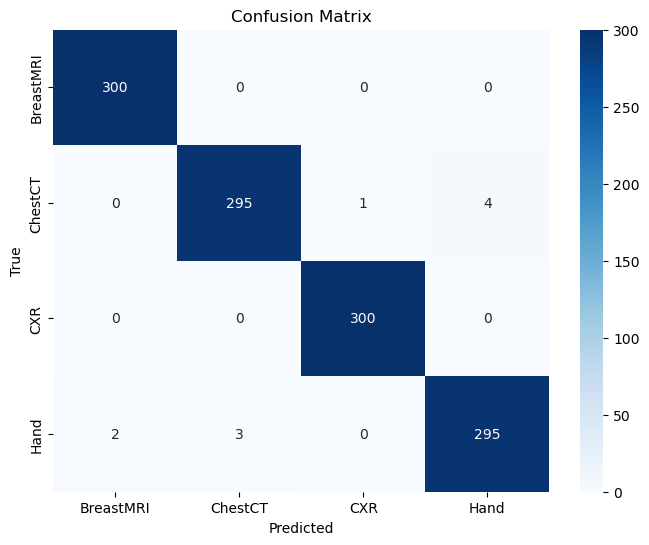

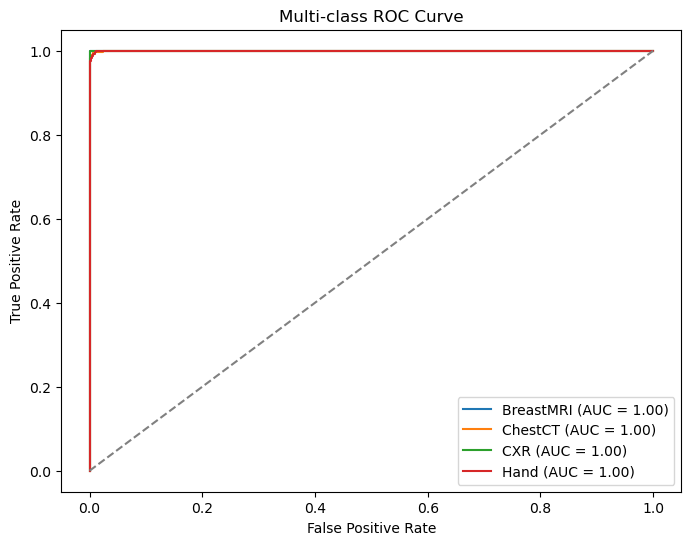

In [117]:
# Εκπαίδευση του μοντέλου με τις καλύτερες υπερπαραμέτρους
best_model = MLP(input_size, best_params['hidden_sizes'], output_size, best_params['dropout_rate'], best_params['use_batchnorm']).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr'])

# Εκπαίδευση του μοντέλου στο πλήρες train set (μετά το cross-validation)
for epoch in range(best_params['num_epochs']):
    best_model.train()
    optimizer.zero_grad()
    
    outputs_train = best_model(X_train_tensor)
    loss_train = criterion(outputs_train, y_train_tensor)
    
    loss_train.backward()
    optimizer.step()

# Μετά την ολοκλήρωση του Cross-Validation, αξιολογούμε το μοντέλο στο test set
best_model.eval()  # Χρησιμοποιούμε το best_model
with torch.no_grad():
    outputs_test = best_model(X_test_tensor)
    _, predicted_test = torch.max(outputs_test, 1)
    test_accuracy = accuracy_score(y_test_tensor.cpu(), predicted_test.cpu())
    print(f'\nTest Accuracy: {test_accuracy * 100:.2f}%')

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test_tensor.cpu(), predicted_test.cpu(), target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test_tensor.cpu(), predicted_test.cpu())
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve - Multi-class ROC Curve
    y_test_bin = label_binarize(y_test_tensor.cpu(), classes=np.arange(len(class_names)))
    outputs_test_softmax = outputs_test.softmax(dim=1).cpu().numpy()  # Softmax για την εκτίμηση των πιθανοτήτων

    # Υπολογισμός του ROC Curve για κάθε κατηγορία
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], outputs_test_softmax[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plotting ROC Curve για κάθε κατηγορία
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
